# Prédicteurs

L'objectif ici est de construire des réseaux prédicteurs capables d'estimer les features audios (rythme, caractéristiques spectrales, ...) à partir de l'espace latent audio.

Par souci de simplicité, on choisit de se concentrer ici simplement sur les caractéristiques spectrales telles le centroïde spectral et la largeur de bande.

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import random
import soundfile as sf
import matplotlib.pyplot as plt

In [90]:
SAMPLE_RATE = 16000
DURATION = 4  # secondes pour le test
NUM_SAMPLES = SAMPLE_RATE * DURATION

## **Etape 0 :** Dataset

On commence par créer un Dataset provisoire constitué de signaux harmoniques et de bruits filtrés pour tester dans un premier temps le fonctionnement de notre prédicteur.

In [91]:
class AudioDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.file_list[idx])
        wav = wav.mean(dim=0)  # mono

        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        wav = wav[:NUM_SAMPLES]
        if wav.shape[0] < NUM_SAMPLES:
            wav = F.pad(wav, (0, NUM_SAMPLES - wav.shape[0]))

        return wav
   
class DebugAudioDataset(Dataset):
    def __init__(self, num_examples=NUM_EXAMPLES):
        self.num_examples = num_examples

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        # Création de la timeline
        t = torch.linspace(0, DURATION, NUM_SAMPLES)

        # Choix aléatoire du type de signal
        choice = random.choice(["harmonic", "filtered_noise"])

        if choice == "harmonic":
            # Son composé de plusieurs sinusoides
            freq = random.uniform(100, 2000)
            audio = torch.sin(2 * math.pi * freq * t) + torch.sin(2 * math.pi * 2*freq * t) + torch.sin(2 * math.pi * 0.7*freq * t) + torch.sin(2 * math.pi * 2.6*freq * t) + torch.sin(2 * math.pi * 3*freq * t)

        elif choice == "filtered_noise":
            f0 = random.uniform(1000,5000) # fréquence centrale
            bw = random.uniform(500,1000)   # bandwidth

            audio = np.random.randn(NUM_SAMPLES)
            fft = np.fft.rfft(audio)
            freqs = np.fft.rfftfreq(NUM_SAMPLES, d=1/SAMPLE_RATE)

            mask = np.zeros_like(freqs)
            mask[(freqs >= f0 - bw/2) & (freqs <= f0 + bw/2)] = 1

            fft_filtered = fft * mask
            audio = np.fft.irfft(fft_filtered)

            audio = torch.FloatTensor(audio)

        # Normalisation entre -1 et 1
        audio = audio / audio.abs().max()

        # Retourne un tensor float32
        return audio.float()


In [109]:
# Dataloader pour le Dataset provisoire
NUM_EXAMPLES = 50

dataset = DebugAudioDataset(NUM_EXAMPLES)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=0 
)

# Test
audio_batch = next(iter(dataloader))
print("Batch shape:", audio_batch.shape)

Batch shape: torch.Size([8, 64000])


## **Etape 1 :** Prédiction des features dans l'espace réel

Pour cela, on a besoin de calculer les spectrogrammes de chaque audio.

In [93]:
N_FFT = 2048       # Taille de la FFT
HOP_LENGTH = 512   # Décalage entre fenêtres

In [94]:
def compute_spectrogram(audio, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE) :

    # vérifier que audio a la bonne forme
    if audio.dim() == 1 :
        audio = audio.unsqueeze(0)

    spec_transf = torchaudio.transforms.Spectrogram(n_fft, hop_length, power=1.0) # spectrograme de magnitude
    spec = spec_transf(audio)

    return spec

Text(0.5, 1.0, 'Spectrogramme')

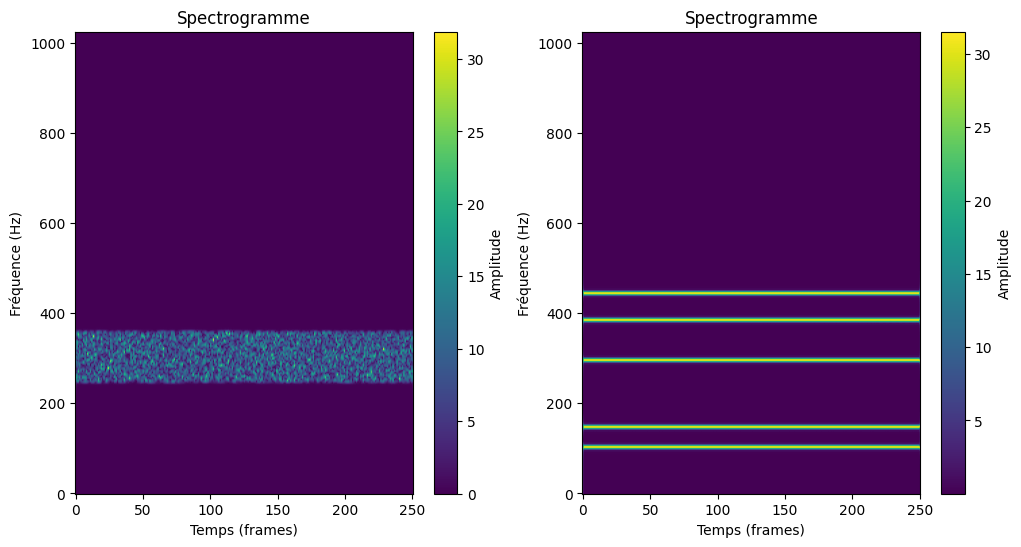

In [69]:
audio0 = dataset[0]
spec0 = compute_spectrogram(audio0)
# convertir en numpy
spec0_np = spec0.cpu().numpy()

audio1 = dataset[1]
spec1 = compute_spectrogram(audio1)
spec1_np = spec1.cpu().numpy()

# plot spectrogram
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(spec0_np[0,:,:], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (frames)')
plt.title("Spectrogramme")

plt.subplot(122)
plt.imshow(spec1_np[0,:,:], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (frames)')
plt.title("Spectrogramme")

On peut à présent en extraire le centroïde spectral et la largeur de bande du spectrogramme $Y$, définis comme :

$$C(n) = \frac{\sum_k k|Y(n,k)|}{\sum_k |Y(n,k)|} $$
$$B(n) = \sqrt{\frac{\sum_{k}(k-C(n))^2 |Y(n,k)|}{\sum_k |Y(n,k)|}}$$

In [95]:
def compute_spectral_features(spec):
    """
    Calcule le centroide spectral et la largeur de bande, moyennés sur toutes les frames temporelles

    Input : 
        spec : (batch, freq_bins, time_frames)
    Outputs :
        centroids : (batch)
        bandwidths : (batch)
    """
    if spec.dim() == 3 :
        batch_size, freq_bins, time_frames = spec.shape
    else :
        batch_size = 1
        freq_bins, time_frames = spec.shape
        spec = spec.unsqueeze(0)
    
    # créer axe des fréquences
    k = torch.arange(freq_bins, dtype=spec.dtype, device=spec.device)
    k = k.view(1, freq_bins, 1)

    spec_abs = torch.abs(spec)
    
    # calcul du centroide
    num = torch.sum(k * spec_abs, dim=1)
    denom = torch.sum(spec_abs, dim=1)
    centroid = num/(denom+1e-8) # éviter la division par zéro
    centroid = torch.mean(centroid, dim=1) # moyenne sur les frames temporelles

    # calcul du bandwidth
    centroid_exp = centroid.unsqueeze(1)
    num = torch.sum((k-centroid_exp)**2 * spec_abs, dim=1)
    denom = torch.sum(spec_abs, dim=1)
    bandwidth = torch.sqrt(num/(denom+1e-8))
    bandwidth = torch.mean(bandwidth, dim=1)

    return centroid, bandwidth

In [80]:
print(compute_spectral_features(spec0))
print(compute_spectral_features(spec1))

(tensor([303.2435]), tensor([33.6131]))
(tensor([276.4818]), tensor([133.8292]))


Les valeurs obtenues sont cohérentes avec les spectrogrammes.

## **Etape 2 :** Création de l'espace latent audio

Pour ce faire, on repart du travail fait dans le notebook ```VQ_VAE_hierarchique_audio_1D.ipynb```.

In [113]:
# Hyperparamètres
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 8
LR = 2e-4
EPOCHS = 20

In [114]:
# Encodeur 1D hiérarchique

class AudioEncoder(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(1, hidden, 4, stride=2, padding=1),
            nn.Conv1d(hidden, hidden, 4, stride=2, padding=1),
            nn.Conv1d(hidden, hidden, 4, stride=2, padding=1),  # LOW
            nn.Conv1d(hidden, hidden, 4, stride=2, padding=1),
            nn.Conv1d(hidden, hidden, 4, stride=2, padding=1),  # UP
        ])

    def forward(self, x):
        h = x.unsqueeze(1)  # (B, 1, T)
        for i, conv in enumerate(self.convs):
            h = F.relu(conv(h))
            if i == 2:
                h_low = h
        h_up = h
        return h_low, h_up

# Vector Quantizer

class VectorQuantizer(nn.Module):
    def __init__(self, num_codes=2048, dim=128, beta=0.25):
        super().__init__()
        self.embedding = nn.Embedding(num_codes, dim)
        self.embedding.weight.data.uniform_(-1/num_codes, 1/num_codes)
        self.beta = beta

    def forward(self, z):
        z_perm = z.permute(0, 2, 1).contiguous()
        z_flat = z_perm.view(-1, z_perm.size(-1))

        dist = (
            z_flat.pow(2).sum(1, keepdim=True)
            - 2 * z_flat @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )

        indices = dist.argmin(1)
        z_q = self.embedding(indices).view(z_perm.shape)
        z_q = z_q.permute(0, 2, 1)

        loss = (
            (z_q.detach() - z).pow(2).mean()
            + self.beta * (z_q - z.detach()).pow(2).mean()
        )

        z_q = z + (z_q - z).detach()
        return z_q, loss

# Décodeur 1D

class AudioDecoder(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.deconvs = nn.ModuleList([
            nn.ConvTranspose1d(hidden, hidden, 4, 2, 1),
            nn.ConvTranspose1d(hidden, hidden, 4, 2, 1),
            nn.ConvTranspose1d(hidden, hidden, 4, 2, 1),
            nn.ConvTranspose1d(hidden, hidden, 4, 2, 1),
            nn.ConvTranspose1d(hidden, 1, 4, 2, 1),
        ])

    def forward(self, z):
        h = z
        for deconv in self.deconvs:
            h = F.relu(deconv(h))
        return h.squeeze(1)

# Loss

def stft_loss(x, x_hat):
    X = torch.stft(x, n_fft=1024, hop_length=256, return_complex=True)
    X_hat = torch.stft(x_hat, n_fft=1024, hop_length=256, return_complex=True)
    return (X.abs() - X_hat.abs()).pow(2).mean()

# Modèle VQ-VAE complet

class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AudioEncoder()
        self.vq_low = VectorQuantizer()
        self.vq_up = VectorQuantizer()
        self.decoder = AudioDecoder()

    def forward(self, x):
        h_low, h_up = self.encoder(x)
        z_low, loss_low = self.vq_low(h_low)
        z_up, loss_up = self.vq_up(h_up)
        x_hat = self.decoder(z_up)
        return x_hat, loss_low + loss_up

In [116]:
# Entraînement du VAE

model = VQVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    for audio in dataloader:
        audio = audio.to(DEVICE)

        audio_hat, loss_vq = model(audio)
        loss_rec = stft_loss(audio, audio_hat)

        loss = loss_vq + loss_rec

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss {loss.item():.4f}")


Epoch 0 | Loss 146.9255
Epoch 1 | Loss 111.6895
Epoch 2 | Loss 105.1877
Epoch 3 | Loss 119.4272
Epoch 4 | Loss 130.3796
Epoch 5 | Loss 117.8721
Epoch 6 | Loss 119.7234
Epoch 7 | Loss 116.7067
Epoch 8 | Loss 105.5980
Epoch 9 | Loss 67.8543
Epoch 10 | Loss 81.9773
Epoch 11 | Loss 92.1159
Epoch 12 | Loss 106.0369
Epoch 13 | Loss 73.7557
Epoch 14 | Loss 103.9414
Epoch 15 | Loss 95.6696
Epoch 16 | Loss 108.8084
Epoch 17 | Loss 118.3515
Epoch 18 | Loss 80.1429
Epoch 19 | Loss 106.4950


## **Phase 3:** Réseaux prédicteurs

In [85]:
class SpectralFeaturePredictor(nn.Module) :
    """
    Prédit les features spectraux depuis l'espace latent
    """

    def __init__(self, latent_dim=128, latent_length=None, hidden_dim=256) :
        """
        Inputs :
            latent_dim : dimension des features latents
            latent_lenght : longeur temporelle de z_low ou z_up
            hidden_dim : dimension cachée de MLP
        """
        super().__init__()
        self.latent_dim = latent_dim
        
        # Architecture: conv1d pour agréger temporellement + MLP
        self.temporal_aggregator = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Agrégation globale
        )
        
        # MLP pour prédire les deux features
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # 2 outputs: centroid et bandwidth
        )
    
    def forward(self, z):
        """
        Args:
            z: latent codes (B, latent_dim, T)
        Returns:
            centroid, bandwidth: (B,), (B,)
        """
        # Agrégation temporelle
        h = self.temporal_aggregator(z)  # (B, hidden_dim, 1)
        h = h.squeeze(-1)                 # (B, hidden_dim)
        
        # Prédiction
        features = self.predictor(h)      # (B, 2)
        centroid = features[:, 0]
        bandwidth = features[:, 1]
        
        return centroid, bandwidth 

On a besoin de construire un Dataset qui contient les labels des features spectrales.

In [82]:
class SpectralFeaturesDataset(Dataset) :
    """
    Calcule les features spectrales comme labels
    """
    def __init__(self, audio_dataset, n_fft=N_FFT, hop_length=HOP_LENGTH):
        self.audio_dataset = audio_dataset
        self.n_fft = n_fft
        self.hop_length = hop_length
    
    def __len__(self):
        return len(self.audio_dataset)
    
    def __getitem__(self, idx):
        # Récupérer l'audio
        audio = self.audio_dataset[idx]
        
        # Calculer le spectrogramme
        spec = compute_spectrogram(audio, self.n_fft, self.hop_length)
        
        # Calculer les features spectrales
        centroid, bandwidth = compute_spectral_features(spec)
        
        return audio, centroid.item(), bandwidth.item()

On peut désormais entraîner le réseau prédicteur.

In [118]:
def train_spectral_predictor(vqvae_model, train_dataset, epochs=30, batch_size=8, lr=1e-4, device=DEVICE):

    # Dataset avec labels
    dataset_with_features = SpectralFeaturesDataset(train_dataset)
    dataloader = DataLoader(
        dataset_with_features,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    predictor = SpectralFeaturePredictor().to(device)

    criterion = nn.MSELoss ()
    optimizer = torch.optim.Adam(predictor.parameters(), lr=lr)

    # Freezer le VQ-VAE
    vqvae_model.eval()
    for param in vqvae_model.parameters():
        param.requires_grad = False

    # Entraînement
    for epoch in range(epochs):
        total_loss = 0
        total_loss_centroid = 0
        total_loss_bandwidth = 0
        
        for audio, target_centroid, target_bandwidth in dataloader:
            audio = audio.to(device)
            target_centroid = torch.tensor(target_centroid, dtype=torch.float32).to(device)
            target_bandwidth = torch.tensor(target_bandwidth, dtype=torch.float32).to(device)
            
            # Encoder l'audio pour obtenir les latents
            with torch.no_grad():
                h_low, h_up = vqvae_model.encoder(audio)
                z_low, _ = vqvae_model.vq_low(h_low)
                z_up, _ = vqvae_model.vq_up(h_up)

            # Prédire les features
            pred_centroid, pred_bandwidth = predictor(z_up)

            # Loss
            loss_centroid = criterion(pred_centroid, target_centroid)
            loss_bandwidth = criterion(pred_bandwidth, target_bandwidth)
            loss = loss_centroid + loss_bandwidth
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_loss_centroid += loss_centroid.item()
            total_loss_bandwidth += loss_bandwidth.item()
        
        avg_loss = total_loss / len(dataloader)
        avg_loss_c = total_loss_centroid / len(dataloader)
        avg_loss_b = total_loss_bandwidth / len(dataloader)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Centroid: {avg_loss_c:.4f} | "
              f"Bandwidth: {avg_loss_b:.4f}")
    
    return predictor
    

In [121]:
predictor = train_spectral_predictor(vqvae_model=model, train_dataset=dataset, epochs=30, batch_size=BATCH_SIZE, lr=5e-4)


C:\Users\colin\AppData\Local\Temp\ipykernel_21856\2950845336.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_centroid = torch.tensor(target_centroid, dtype=torch.float32).to(device)
C:\Users\colin\AppData\Local\Temp\ipykernel_21856\2950845336.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_bandwidth = torch.tensor(target_bandwidth, dtype=torch.float32).to(device)


Epoch 1/30 | Loss: 144839.7511 | Centroid: 135877.0893 | Bandwidth: 8962.6624
Epoch 2/30 | Loss: 118370.6473 | Centroid: 111539.7852 | Bandwidth: 6830.8609
Epoch 3/30 | Loss: 148226.2623 | Centroid: 139985.6775 | Bandwidth: 8240.5874
Epoch 4/30 | Loss: 143337.0022 | Centroid: 136758.8594 | Bandwidth: 6578.1430
Epoch 5/30 | Loss: 100154.5993 | Centroid: 94292.1133 | Bandwidth: 5862.4850
Epoch 6/30 | Loss: 139563.8281 | Centroid: 130793.2020 | Bandwidth: 8770.6274
Epoch 7/30 | Loss: 132106.6730 | Centroid: 124967.6763 | Bandwidth: 7138.9982
Epoch 8/30 | Loss: 75999.8945 | Centroid: 72072.5619 | Bandwidth: 3927.3330
Epoch 9/30 | Loss: 53483.2913 | Centroid: 48541.8496 | Bandwidth: 4941.4413
Epoch 10/30 | Loss: 29382.8412 | Centroid: 24496.7607 | Bandwidth: 4886.0805
Epoch 11/30 | Loss: 33061.7762 | Centroid: 26814.5912 | Bandwidth: 6247.1848
Epoch 12/30 | Loss: 28215.1685 | Centroid: 24676.9187 | Bandwidth: 3538.2495
Epoch 13/30 | Loss: 28548.4194 | Centroid: 23805.6533 | Bandwidth: 4742.

Finalement on réalise l'évaluation.

In [122]:
def evaluate_predictor(vqvae_model, predictor, test_dataset, device=DEVICE):
    """
    Évalue le prédicteur sur un dataset de test
    """
    vqvae_model.eval()
    predictor.eval()
    
    dataset_with_features = SpectralFeaturesDataset(test_dataset)
    dataloader = DataLoader(dataset_with_features, batch_size=8, shuffle=False)
    
    all_pred_centroids = []
    all_true_centroids = []
    all_pred_bandwidths = []
    all_true_bandwidths = []
    
    with torch.no_grad():
        for audio, target_centroid, target_bandwidth in dataloader:
            audio = audio.to(device)
            
            # Encoder
            h_low, h_up = vqvae_model.encoder(audio)
            z_low, _ = vqvae_model.vq_low(h_low)
            z_up, _ = vqvae_model.vq_up(h_up)

            # Prédire
            pred_centroid, pred_bandwidth = predictor(z_up)
            
            all_pred_centroids.extend(pred_centroid.cpu().numpy())
            all_true_centroids.extend(target_centroid)
            all_pred_bandwidths.extend(pred_bandwidth.cpu().numpy())
            all_true_bandwidths.extend(target_bandwidth)

    # Calculer les erreurs
    err_centroid = np.mean(np.abs(np.array(all_pred_centroids) - np.array(all_true_centroids)))
    err_bandwidth = np.mean(np.abs(np.array(all_pred_bandwidths) - np.array(all_true_bandwidths)))
    
    print(f"Erreur absolue moyenne sur le Centroid: {err_centroid:.4f}")
    print(f"Erreur absolue moyenne sur la Bandwidth: {err_bandwidth:.4f}")

    # Visualisation
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(all_true_centroids, all_pred_centroids, alpha=0.5)
    axes[0].plot([min(all_true_centroids), max(all_true_centroids)], 
                 [min(all_true_centroids), max(all_true_centroids)], 'r--')
    axes[0].set_xlabel('True Centroid')
    axes[0].set_ylabel('Predicted Centroid')
    axes[0].set_title('Centroid Spectral')
    axes[0].grid(True)
    
    axes[1].scatter(all_true_bandwidths, all_pred_bandwidths, alpha=0.5)
    axes[1].plot([min(all_true_bandwidths), max(all_true_bandwidths)], 
                 [min(all_true_bandwidths), max(all_true_bandwidths)], 'r--')
    axes[1].set_xlabel('True Bandwidth')
    axes[1].set_ylabel('Predicted Bandwidth')
    axes[1].set_title('Bandwidth Spectral')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

Erreur absolue moyenne sur le Centroid: 126.4136
Erreur absolue moyenne sur la Bandwidth: 57.7714


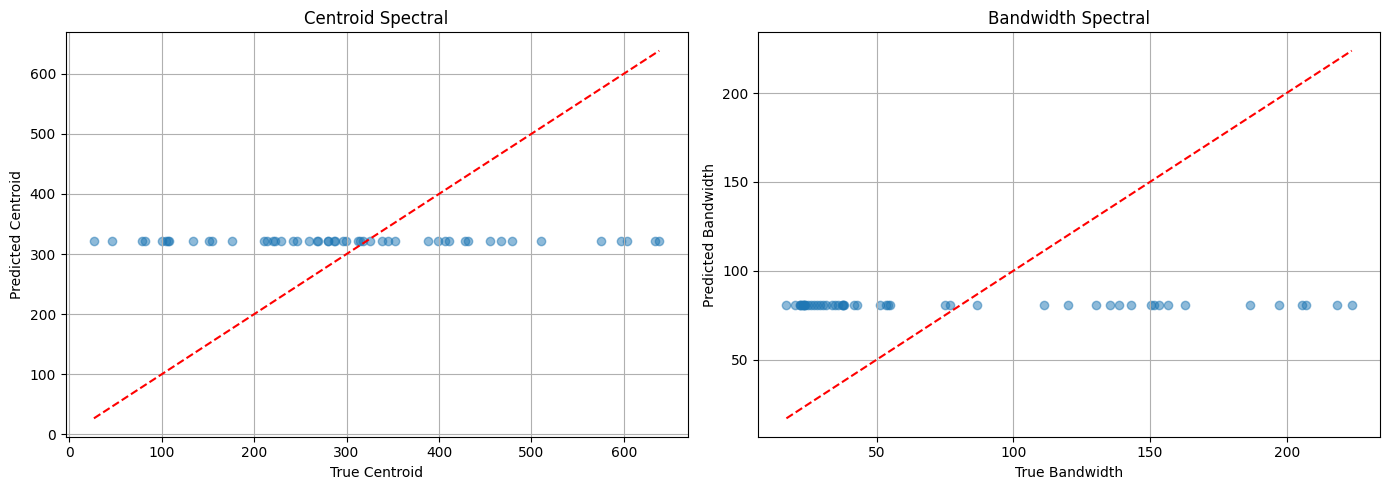

In [123]:
test_dataset = DebugAudioDataset(num_examples=50)
evaluate_predictor(model, predictor, test_dataset)

Les points bleux représente la prédiction en fonction de la valeur vraie, tandis que la droite rouge est la droite de prédiction parfaite.

On observe que le réseau prédicteur estime toujours la même valeur, ce qui signifie qu'il a appris uniquelent à prédire la moyenne du dataset. Cela peut s'expliquer par l'entraînement du VAE et du réseau prédicteur sur un nombre trop faible de données. Néanmoins, nous ne disposons pas de la puissance calculatoire nécessaire. On peut donc simplement valider notre approche qui semble être capable de prédire les features audios à partir de l'espace latent, mais les paramètres optimaux de l'entraînement ne sont pas encore atteints.